In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Data Preparation

In [5]:
base_path = '../Data/2023-24/gws/gw{}.csv'  # Base path template

num_gameweeks = 24 # Adjust based on available data

gw_data_frames = {gw: pd.read_csv(base_path.format(gw)) for gw in range(1, num_gameweeks + 1)}

In [6]:
# Add a 'gw' column to each DataFrame to indicate the game week, then concatenate them into one DataFrame
for gw, df in gw_data_frames.items():
    df['gw'] = gw

combined_df = pd.concat(gw_data_frames.values(), ignore_index=True)

## Feature Selection

In [7]:
def create_defender_features(gw_data_frames, up_to_gw):
    """
    Create defender features DataFrame up to a specified gameweek.

    Parameters:
    - gw_data_frames: Dictionary of DataFrames for each gameweek.
    - up_to_gw: Integer, the last gameweek to include in the feature calculation.

    Returns:
    - DataFrame with defender features calculated up to the specified gameweek.
    """
    # Combine DataFrames up to the specified gameweek
    combined_df = pd.concat([df for gw, df in gw_data_frames.items() if gw <= up_to_gw], ignore_index=True)

    # Filter for defenders
    df_defender = combined_df.loc[combined_df['position'] == 'DEF']

    # Group by player name
    defender_grouped = df_defender.groupby('name')

    # Initialize the features DataFrame
    defender_features = pd.DataFrame(index=defender_grouped.indices.keys())

    # Calculate features relevant to defenders
    defender_features['minutes'] = defender_grouped['minutes'].mean()
    defender_features['clean_sheets'] = defender_grouped['clean_sheets'].sum()
    defender_features['goals_conceded'] = defender_grouped['goals_conceded'].mean()
    defender_features['goals_scored'] = defender_grouped['goals_scored'].sum()  # Points for goals scored by defenders
    defender_features['assists'] = defender_grouped['assists'].sum()
    defender_features['bonus'] = defender_grouped['bonus'].mean()
    defender_features['yellow_cards'] = defender_grouped['yellow_cards'].sum()  # Points deduction for yellow cards
    defender_features['red_cards'] = defender_grouped['red_cards'].sum()  # Points deduction for red cards
    defender_features['own_goals'] = defender_grouped['own_goals'].sum()  # Points deduction for own goals

    # Calculate recent form (total points in the last 5 games)
    recent_form = []
    for name, group in defender_grouped:
        group = group.sort_values(by='gw', ascending=False)
        recent_form.append(group['total_points'].head(5).sum())
    defender_features['recent_form'] = recent_form

    return defender_features

## Random Forest Model MSE Evaluation

In [10]:
def train_and_evaluate_rf(gw_data_frames, target_gw):
    """
    Train a Random Forest model with data up to a specified gameweek and evaluate it using the target gameweek.
    Automatically excludes defenders not present in the feature set.

    Parameters:
    - gw_data_frames: Dictionary of DataFrames for each gameweek.
    - target_gw: Integer, the gameweek to predict and evaluate the model.

    Returns:
    - mse: Mean Squared Error of the model predictions for the target gameweek.
    """
    
    defender_features = create_defender_features(gw_data_frames, target_gw - 1)
    
    # Load target gameweek data
    gw_target_data = gw_data_frames[target_gw]
    gw_target_defender = gw_target_data.loc[gw_target_data['position'] == 'DEF']
    
    # Prepare target variable
    y = gw_target_defender[['name', 'total_points']].set_index('name').sort_index()

    common_indices = defender_features.index.intersection(y.index)
    x_filtered = defender_features.loc[common_indices]
    y_filtered = y.loc[common_indices]

    # Check if sufficient data is available for split
    if len(x_filtered) < 5 or len(y_filtered) < 5:
        print(f"Insufficient data for gameweek {target_gw}. Skipping.")
        return None

    try:
        X_train, X_test, y_train, y_test = train_test_split(x_filtered, y_filtered, test_size=0.2, shuffle=False)
    except ValueError as e:
        print(f"Error splitting data for gameweek {target_gw}: {e}")
        return None

    # Train the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train.values.ravel())  # .values.ravel() to convert y_train to 1D array if needed

    # Predict and evaluate
    y_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

In [11]:
for gw in range(2, num_gameweeks + 1):
    mse = train_and_evaluate_rf(gw_data_frames, gw)
    if mse is not None:
        print(f"Gameweek {gw} - MSE: {mse:.2f}")

Gameweek 2 - MSE: 4.67
Gameweek 3 - MSE: 2.40
Gameweek 4 - MSE: 7.61
Gameweek 5 - MSE: 5.34
Gameweek 6 - MSE: 5.86
Error splitting data for gameweek 7: Found input variables with inconsistent numbers of samples: [232, 256]
Gameweek 8 - MSE: 4.29
Gameweek 9 - MSE: 2.75
Gameweek 10 - MSE: 5.24
Gameweek 11 - MSE: 8.45
Gameweek 12 - MSE: 10.47
Gameweek 13 - MSE: 4.11
Gameweek 14 - MSE: 6.40
Gameweek 15 - MSE: 8.41
Gameweek 16 - MSE: 5.47
Gameweek 17 - MSE: 7.62
Gameweek 18 - MSE: 2.09
Gameweek 19 - MSE: 1.43
Gameweek 20 - MSE: 2.72
Gameweek 21 - MSE: 3.79
Gameweek 22 - MSE: 3.61
Gameweek 23 - MSE: 2.39
Gameweek 24 - MSE: 6.04


## Results and Visualization

In [12]:
defender_features = create_defender_features(gw_data_frames, num_gameweeks - 1)

# Load target gameweek data
gw_target_data = gw_data_frames[num_gameweeks]
gw_target_defender = gw_target_data.loc[gw_target_data['position'] == 'DEF']

# Prepare target variable
y = gw_target_defender[['name', 'total_points']].set_index('name').sort_index()

# Ensure we only consider defenders present in both the features and target sets
common_indices = defender_features.index.intersection(y.index)
x_filtered = defender_features.loc[common_indices]
y_filtered = y.loc[common_indices]


try:
    X_train, X_test, y_train, y_test = train_test_split(x_filtered, y_filtered, test_size=0.2, shuffle=False)
except ValueError as e:
    print(f"Error splitting data for gameweek {num_gameweeks}: {e}")

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train.values.ravel())  # .values.ravel() to convert y_train to 1D array if needed

# Predict and evaluate
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)



In [13]:
# Convert predictions to a pandas Series for easy handling, align with y_test index
predictions_series = pd.Series(y_pred, index=y_test.index, name='Predicted Points')

# Create a DataFrame combining actual and predicted values
results_df = pd.DataFrame(y_test)
results_df['Predicted Points'] = predictions_series

In [14]:
# Predictions on the training set
train_predictions = rf_model.predict(X_train)

# Convert training predictions to a pandas Series for easy handling
train_predictions_series = pd.Series(train_predictions, index=y_train.index, name='Predicted Points')

# Create a DataFrame for the training set combining actual and predicted values
train_results_df = pd.DataFrame(y_train)
train_results_df['Predicted Points'] = train_predictions_series

# For the test set, you've already got predictions_series and results_df as per your previous code

# Optionally, you can concatenate the training and test results into a single DataFrame
# if you want to analyze them together
all_results_df = pd.concat([train_results_df, results_df])

# Display the combined DataFrame
print(all_results_df)

                           total_points  Predicted Points
Aaron Cresswell                       1          0.710000
Aaron Hickey                          0          0.310000
Aaron Wan-Bissaka                     0          0.930000
Abdul Rahman Baba                     0          0.013891
Adam Smith                            0          1.860000
...                                 ...               ...
Willy Boly                            0          0.550000
Willy Kambwala                        0          0.590000
Yasser Larouci                        0          0.700000
Yerson Mosquera                       0          0.013891
Álvaro Fernández Carreras             0          0.013891

[261 rows x 2 columns]


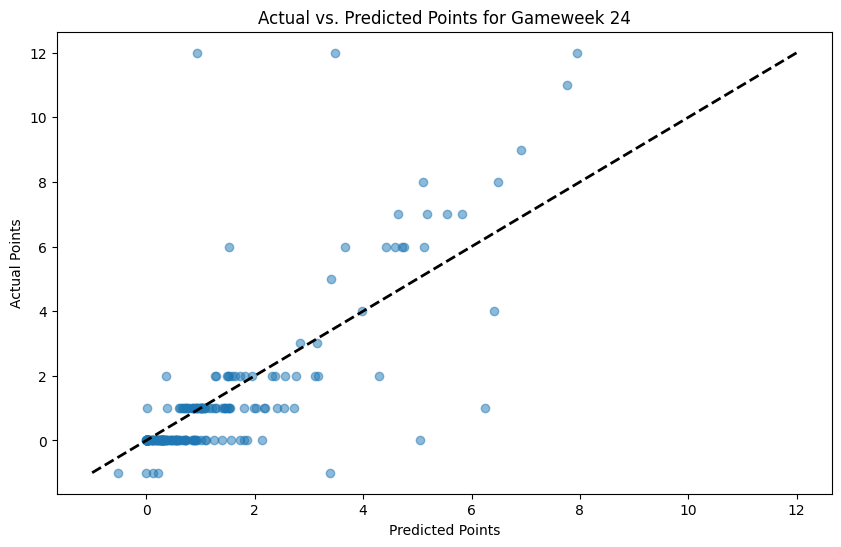

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(all_results_df['Predicted Points'], all_results_df['total_points'], alpha=0.5)
plt.title('Actual vs. Predicted Points for Gameweek {}'.format(num_gameweeks))
plt.xlabel('Predicted Points')
plt.ylabel('Actual Points')
plt.plot([all_results_df.min().min(), all_results_df.max().max()], [all_results_df.min().min(), all_results_df.max().max()], 'k--', lw=2)  # Diagonal line
plt.show()